In [1]:
import pandas as pd
import numpy as np
import torch 
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
import glob, os, pickle
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
import dgl
from torch_geometric.utils import dropout_edge
from sklearn.metrics import roc_auc_score
import torch.optim as optim
import torchvision.ops.focal_loss

In [2]:
import torch.nn.functional as F 
from torch.nn import Linear, BatchNorm1d, ModuleList
from torch_geometric.nn import TransformerConv, TopKPooling, GATConv, SAGEConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

In [3]:
!nvidia-smi

Thu Dec 29 02:57:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:18:00.0 Off |                    0 |
| N/A   35C    P0    52W / 300W |      0MiB / 32768MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
device 

device(type='cuda', index=0)

# Need to define the data class 
- Here focus mainly on the get() method. We don't need to process anything
- We also return masks for each graph, that will help with training 
- Actually, no masks. Inductive training.
- We are no longer using this data class

In [6]:
# class WSI_Graph_Class(Dataset):
    
#     def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
#         super().__init__(None, transform, pre_transform)
#         self.root_dir = root
#         self.WSI_df = pd.read_csv(root) #get the WSI metadata
#         self.masks = {} #map node num -> train/val/test masks
#         self.create_all_masks()
        
#     def create_all_masks(self):
        
#         for idx in tqdm(range(len(self.WSI_df["sample_id"]))):
#             path = self.WSI_df["path"].iloc[idx]
            
#             #this is the graph. We also need to return the training/validation/testing masks 
#             data = torch.load(path)
#             nodes = [i for i in range(data.x.shape[0])] #node 0 is in 0th pos, 1 in 1, and so on 
            
#             #all of the masks 
#             train_mask = [False] * len(nodes)
#             val_mask = [False] * len(nodes)
#             test_mask = [False] * len(nodes)
#             self.create_mask(nodes, train_mask, val_mask, test_mask)
#             #now add them to dictionary
#             self.masks[idx] = [train_mask, val_mask, test_mask]
        
        
#     def create_mask(self, nodes, train_mask, val_mask, test_mask):        
#         #create train/test/val nodes (75/25)
#         train, test = train_test_split(nodes)
#         test, val = train_test_split(test)
        
#         #now create masks
#         for i in range(len(nodes)):
#             if i in train: 
#                 train_mask[i] = True 
                
#         for i in range(len(nodes)):
#             if nodes[i] in val: 
#                 val_mask[i] = True 
                
#         for i in range(len(nodes)):
#             if nodes[i] in test: 
#                 test_mask[i] = True 
                
#     #just pass here, we aren't going to return any raw file names
#     def raw_file_names(self):
#         pass 
#     #here we can return each of the WSI 
#     def processed_file_names(self):
#         return list(self.WSI_df["sample_id"])
    
#     def len(self):
#         return len(self.processed_file_names())
    
#     #return the graph class for that idx 
#     def get(self, idx):
#         path = self.WSI_df["path"].iloc[idx]
#         #this is the graph. We also need to return the training/validation/testing masks 
#         data = torch.load(path)
#         masks = self.masks[idx]
#         train_mask = masks[0]
#         val_mask = masks[1]
#         test_mask = masks[2]
#         return (data, torch.tensor(train_mask), torch.tensor(val_mask), torch.tensor(test_mask))

In [7]:
# root = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/graph_data/metadata.csv"

# dataset = WSI_Graph_Class(root = root, transform = None, pre_transform = None, pre_filter = None)

# Define Model 
- This mainly draws upon HIV project code 

In [6]:
torch.manual_seed(42)

# class GNN(torch.nn.Module):
#     def __init__(self, feature_size):
#         super(GNN, self).__init__()
#         num_classes = 2
#         embedding_size = 2048 # from resnet  

#         #define the GNN layers 

#         #layer 1
#         #the first graph attention layer which will create 3*embed size embeddings for each node. This will also take care of all the message passing and aggregation
#         self.conv1 = GATConv(feature_size, embedding_size, heads=3, dropout = 0.3)
#         #reduce the dimensionality back
#         self.head_transform1 = Linear(embedding_size*3, embedding_size)
#         self.pool1 = TopKPooling(embedding_size, ratio=0.8)

#         #layer 2
#         self.conv2 = GATConv(embedding_size, embedding_size, heads=3, dropout = 0.3)
#         self.head_transform2 = Linear(embedding_size*3, embedding_size)
#         self.pool2 = TopKPooling(embedding_size, ratio=0.5)

#         #layer 3
#         self.conv3 = GATConv(embedding_size, embedding_size, heads=3, dropout = 0.3)
#         self.head_transform3 = Linear(embedding_size*3, embedding_size)
#         self.pool3 = TopKPooling(embedding_size, ratio=0.2)


#         #linear layers - these need to be modified to match the output size? Or maybe not
#         self.linear1 = Linear(embedding_size*2, embedding_size)
#         self.linear2 = Linear(embedding_size, 2)

#     def forward(self, x, edge_attr, edge_index, batch_index):
#         #block 1 
#         x = self.conv1(x, edge_index)
#         x = self.head_transform1(x)

#         x, edge_index, edge_attr, batch_index, _, _ = self.pool1(x, edge_index, None, batch_index)
#         #graph rep. 
#         x1 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)
#         #block 2 
#         x = self.conv2(x, edge_index)
#         x = self.head_transform2(x)

#         x, edge_index, edge_attr, batch_index, _, _ = self.pool2(x, edge_index, None, batch_index)
#         #graph rep. 
#         x2 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)
#         #block 3
#         x = self.conv3(x, edge_index)
#         x = self.head_transform3(x)

#         x, edge_index, edge_attr, batch_index, _, _ = self.pool3(x, edge_index, None, batch_index)
#         #graph rep. 
#         x3 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)
#         #element wise addition , and each is 2048 
#         x = x1 + x2 + x3
#         #output block 
#         x = self.linear1(x).relu()
#         x = F.dropout(x, p=0.5)
#         x = self.linear2(x)

#         return x

In [7]:
torch.manual_seed(42)

class simple_GNN(torch.nn.Module):
    def __init__(self, feature_size):
        super(simple_GNN, self).__init__()
        
        self.num_classes = 2 #scc or normal
        self.embedding_size = 2048 # this is what we want the embedding to be
        
        self.linear1 = Linear(self.embedding_size, 128)
        #define the GNN layers 
        
        self.drop_edge = lambda edge_index: dropout_edge(edge_index,p=0.3)[0]
        self.layer_norm = nn.LayerNorm(128)
        #layer 1
        #the first graph attention layer which will create 3*embed size embeddings for each node. This will also take care of all the message passing and aggregation
        self.conv1 = GATConv(128, 128, heads=3, dropout = 0.3)
        #reduce the dimensionality back
        self.head_transform1 = Linear(256*3, 256)
        
        #layer 2
        self.conv2 = GATConv(256, 256, heads=3, dropout = 0.3)
        self.head_transform2 = Linear(256*3, 256)

        #layer 3
        self.conv3 = GATConv(256, 256, heads=3, dropout = 0.3)
        self.head_transform3 = Linear(256*3, 256)
        
#         #layer 4
#         self.conv4 = GATConv(128, 256, heads=3, dropout = 0.3)
#         self.head_transform4 = Linear(256*3, 256)
        
        #linear layers - these need to be modified to match the output size? Or maybe not
        self.linear2 = Linear(256, 64) 
        self.linear3 = Linear(64, self.num_classes) #prediction for each class

    def forward(self, x, edge_index, batch):
        x = x 
        edge_index = edge_index
        batch = batch 
        # downsize the embeddings
        x = self.linear1(x).relu()
        
        #block 1 
        x = self.conv1(x, edge_index) #this is does all the aggregation and message passing
        x = self.head_transform1(x)       
        x = self.layer_norm(x)
        #block 2
#         edge_index = self.drop_edge(edge_index)
        x = self.conv2(x, edge_index) 
        x = self.head_transform2(x)      
        x = self.layer_norm(x)

        #block 3
#         edge_index = self.drop_edge(edge_index)
        x = self.conv3(x, edge_index) #this is does all the aggregation and message passing
        x = self.head_transform3(x)   
        x = self.layer_norm(x)

#         #block 4
# #         edge_index = self.drop_edge(edge_index)
#         x = self.conv4(x, edge_index) 
#         x = self.head_transform4(x)   
        
        #output block 
        x = self.linear2(x).relu()
        x = F.dropout(x, p=0.5)
        x = self.linear3(x)
        
#         print("Inside model, after all computations", torch.cuda.memory_summary(device=None, abbreviated=False)) #bulk of the memory is used here, somehow

        return x

In [8]:
class sage_GNN(torch.nn.Module):
    def __init__(self, feature_size):
        super(sage_GNN, self).__init__()
        
        self.num_classes = 2 #scc or normal
        self.embedding_size = 2048 # this is what we want the embedding to be
        
        self.linear1 = Linear(2048, 512)

        #define the GNN layers 
    
        #layer 1
        self.conv1 = SAGEConv(512, 128)
        
        #layer 2
        self.conv2 = SAGEConv(128, 128)
           
        #layer 3
        self.conv3 = SAGEConv(128,128)

        self.linear2 = Linear(128, 64) 
        self.linear3 = Linear(64, 2)

    def forward(self, x, edge_index, batch):
        x = self.linear1(x).relu()
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

In [9]:
class simple_NN(torch.nn.Module):
    def __init__(self, embedding_size):
        super(simple_NN, self).__init__()
        

        self.linear = Linear(2048, 512) 
        self.linear2 = Linear(512, 64)
        self.linear3 = Linear(64, 2)

    def forward(self, x, edge_index, batch):
        
        x = F.relu(self.linear(x))
        x = F.relu(self.linear2(x))
        x = F.dropout(x, p=0.5)
        x = self.linear3(x)

        return x

# Dataloader

In [10]:
# num_features = 2048

# # device_ids = [0, 1]
# model = simple_GNN(2048)
# # model= nn.DataParallel(model, device_ids = device_ids)
# model = model.to(device)

In [11]:
# model

In [12]:
# #loss and optimizer 
# import torch.optim as optim
# import torchvision.ops.focal_loss

# # loss_fn = torchvision.ops.focal_loss.sigmoid_focal_loss
# loss_fn = nn.CrossEntropyLoss()
# opt = optim.Adam(model.parameters(), lr=1e-7)

In [13]:
# #prepare training 
# from torch_geometric.data import DataLoader

# # train_loader = DataLoader(training_data, batch_size=1, shuffle=True)
# # val_loader = DataLoader(val_data, batch_size=1, shuffle=True)
# # test_loader = DataLoader(testing_data, batch_size=1, shuffle=True)

# # num_epochs = 500

In [14]:
# from sklearn.metrics import roc_auc_score

# softmax = nn.Softmax(dim=1)

# Inductive Model Training on Gokul Data

In [15]:
# for epoch in range(num_epochs):
#     #training portion
#     model.train()
#     epoch_loss = []
#     for data in tqdm(train_loader):
#         #get graph and the relevant stuff
#         graph = data[0]
#         x = data[0].x
#         edge_index = data[0].edge_index
#         y = data[0].y
        
#         #move to device
#         x = x.to(device)
#         edge_index = edge_index.to(device)
#         y = y.to(device)

#         #get predictions 
#         logits = model(x, edge_index)
#         loss = loss_fn(logits, y) #for CE

#         epoch_loss.append(loss.item())

#         opt.zero_grad()
#         loss.backward()
#         opt.step()
#     #now find the average training loss for this epoch 
#     epoch_loss = sum(epoch_loss)/len(epoch_loss)
#     print("Epoch :%d. Epoch loss: %f" %(epoch, epoch_loss))    
#     #validation portion
#     validation_correct = 0
#     validation_total = 0
#     model.eval()
#     with torch.no_grad():
#         for data in tqdm(val_loader):
#             #get graph
#             graph = data[0]
#             x = data[0].x
#             edge_index = data[0].edge_index
#             y = data[0].y
        
#             #move to device
#             x = x.to(device)
#             edge_index = edge_index.to(device)
#             y = y.to(device)

#             #get predictions 
#             logits = model(x, edge_index)
#             #get them into label predictions
#             _, indices = torch.max(logits, dim=1)
# #             print(indices)
#             validation_correct += sum(indices == y).item()
#             validation_total += len(y)
# #             print("Accuracy on this graph's val set", sum(indices == y).item()/len(y))
# #             print("SCC percent", sum(y == 1).item()/len(y))
    
#     print("Epoch :%d. Validation accuracy: %f" %(epoch, validation_correct/validation_total))

In [16]:
#  #test portion
# test_correct = 0
# test_total = 0
# model.eval()
# with torch.no_grad():
#     for data in tqdm(data_loader):
#         #get graph
#         graph = data[0]
#         x = graph.x 
#         edge_index = graph.edge_index
#         y = graph.y 
#         #move to device
#         x = x.to(device)
#         edge_index = edge_index.to(device)
#         y = y.to(device)
#         #get masks
#         test_mask = data[3].T.reshape([data[3].T.shape[0]])

#         #get predictions 
#         logits = model(x, edge_index)
#         #get them into label predictions
#         _, indices = torch.max(logits, dim=1)
#         print(1 in indices)
#         test_correct += sum(indices[test_mask] == y[test_mask]).item()
#         test_total += sum(test_mask == True).item()

# print("Test accuracy: %f" %(test_correct/test_total))

# Training With Sophie Data
- Here, use inductive training 
- split the ids themselves into different categories 

In [17]:
sophie_data = pd.read_pickle("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/graph_dataset/graph_dataset_modified.pkl")

In [18]:
sophie_data

{'109_A1c_ASAP_tumor_map': [[Data(x=[41295, 2048], edge_index=[2, 204923], y=[41295], pos=[41295, 2], train_mask=[41295], val_mask=[41295], test_mask=[41295])]],
 '10_A1a_ASAP_tumor_map': [[Data(x=[16468, 2048], edge_index=[2, 80814], y=[16468], pos=[16468, 2], train_mask=[16468], val_mask=[16468], test_mask=[16468])]],
 '10_A1b_ASAP_tumor_map': [[Data(x=[17010, 2048], edge_index=[2, 83576], y=[17010], pos=[17010, 2], train_mask=[17010], val_mask=[17010], test_mask=[17010])]],
 '10_A2b_ASAP_tumor_map': [[Data(x=[18422, 2048], edge_index=[2, 90600], y=[18422], pos=[18422, 2], train_mask=[18422], val_mask=[18422], test_mask=[18422])]],
 '110_A2b_ASAP_tumor_map': [[Data(x=[17856, 2048], edge_index=[2, 87348], y=[17856], pos=[17856, 2], train_mask=[17856], val_mask=[17856], test_mask=[17856])]],
 '112_a_ASAP_tumor_map': [[Data(x=[6217, 2048], edge_index=[2, 29695], y=[6217], pos=[6217, 2], train_mask=[6217], val_mask=[6217], test_mask=[6217])]],
 '112_b_ASAP_tumor_map': [[Data(x=[6828, 204

In [19]:
len(sophie_data)

95

In [20]:
dataset_ids = []
for id in sophie_data:
    dataset_ids.append(id)

In [21]:
len(dataset_ids)

95

In [22]:
train_ids, test_ids = train_test_split(dataset_ids, train_size = .9, test_size = .1)

In [23]:
print(len(train_ids), len(test_ids))

85 10


In [24]:
train_ids, val_ids = train_test_split(train_ids, train_size = .9, test_size = .1)

In [25]:
print(len(train_ids), len(val_ids))

76 9


In [26]:
print(len(train_ids), len(test_ids), len(val_ids))

76 10 9


In [27]:
#here collect all of the graphs - expect sophie's data set doesn't have test sets, only test masks

train_dataset = []

for id in train_ids:
    train_dataset.append(sophie_data[id][0][0])

In [28]:
val_dataset = []

for id in val_ids:
    val_dataset.append(sophie_data[id][0][0])

In [29]:
test_dataset = []

for id in test_ids:
    test_dataset.append(sophie_data[id][0][0])

In [41]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=5)
val_loader = DataLoader(val_dataset, batch_size=5)
test_loader = DataLoader(test_dataset, batch_size=5)

/dartfs-hpc/rc/home/9/f003xr9/anaconda3/envs/jupyter_ultimate/lib/python3.7/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [42]:
print(len(train_loader), len(val_loader), len(test_loader))
num_epochs = 500

16 2 2


In [50]:
num_features = 2048

# device_ids = [0, 1]
model = simple_GNN(2048)
# model= nn.DataParallel(model, device_ids = device_ids)
model = model.to(device)

#loss and optimizer 
# loss_fn = torchvision.ops.focal_loss.sigmoid_focal_loss
loss_fn = nn.CrossEntropyLoss()

#optim and scheduler
opt = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, patience = 5, verbose = True)
softmax = nn.Softmax(dim=1)

In [51]:
lossess = []
rocs = []

# Experiment notes
- So 2 layers seems to work well with fairly small embedding sizes
- increasing embed size doesn't seem to improve performance 
- 1e-5 works well with CE
- simple NN baseline easily achieves .70 AUC

In [ ]:
for epoch in range(num_epochs):
    #training portion
    model.train()
    epoch_loss = []
    for data in tqdm(train_loader):
        #get graph and the relevant stuff
        graph = data
        x = data.x
        edge_index = data.edge_index
        y = data.y
        batch = data.batch 
        
        #move to device
        x = x.to(device)
        edge_index = edge_index.to(device)
        y = y.to(device)
        batch = batch.to(device)
        #get predictions 
        logits = model(x, edge_index, batch) #for CE - CE takes logics 
#         scores = softmax(model(x, edge_index, batch))[:, 1] # for FL - takes the class prob
        loss = loss_fn(logits, y) #for CE
#         loss = loss_fn(scores, y.float()).sum() #for focal loss
        epoch_loss.append(loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()
    
    #now find the average training loss for this epoch 
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    lossess.append(epoch_loss) #append to master array 
    print("Epoch :%d. Epoch loss: %f" %(epoch, epoch_loss)) 
    
    scheduler.step(epoch_loss) #show the scheduler the epoch loss and adjust lr accordingly
    
    
    #validation portion
    probabilities = torch.Tensor([])
    ground_truth = torch.Tensor([])
    model.eval()
    with torch.no_grad():
        for data in tqdm(val_loader):
            #get graph
            graph = data
            x = graph.x 
            edge_index = graph.edge_index
            y = graph.y 
            batch = graph.batch
            
            #move to device
            x = x.to(device)
            edge_index = edge_index.to(device)
            y = y.to(device)
            batch = batch.to(device)
            
            #find the probs
            scores = softmax(model(x, edge_index, batch))

            #move to cpu
            scores = scores.detach().cpu()
            y = y.detach().cpu()

            #concat them 
            probabilities = torch.cat((probabilities, scores))
            ground_truth = torch.cat((ground_truth, y))
    roc = roc_auc_score(ground_truth, probabilities[:, 1])
    rocs.append(roc) #add to ROC master array 
    print("Epoch :%d. Validation AUC-ROC: %f" %(epoch, roc))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.96it/s]


Epoch :0. Epoch loss: 0.566635


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.46it/s]


Epoch :0. Validation AUC-ROC: 0.472387


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.99it/s]


Epoch :1. Epoch loss: 0.475673


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.48it/s]


Epoch :1. Validation AUC-ROC: 0.474952


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.99it/s]


Epoch :2. Epoch loss: 0.463837


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.48it/s]


Epoch :2. Validation AUC-ROC: 0.471819


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.99it/s]


Epoch :3. Epoch loss: 0.450095


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.19it/s]


Epoch :3. Validation AUC-ROC: 0.489778


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.98it/s]


Epoch :4. Epoch loss: 0.433686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.50it/s]


Epoch :4. Validation AUC-ROC: 0.506980


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.98it/s]


Epoch :5. Epoch loss: 0.414155


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.21it/s]


Epoch :5. Validation AUC-ROC: 0.535790


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.99it/s]


Epoch :6. Epoch loss: 0.393314


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.39it/s]


Epoch :6. Validation AUC-ROC: 0.563334


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.99it/s]


Epoch :7. Epoch loss: 0.374326


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.47it/s]


Epoch :7. Validation AUC-ROC: 0.577998


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.99it/s]


Epoch :8. Epoch loss: 0.360694


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.48it/s]


Epoch :8. Validation AUC-ROC: 0.581829


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.99it/s]


Epoch :9. Epoch loss: 0.351305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.47it/s]


Epoch :9. Validation AUC-ROC: 0.589235


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.99it/s]


Epoch :10. Epoch loss: 0.345530


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.50it/s]


Epoch :10. Validation AUC-ROC: 0.595017


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.99it/s]


Epoch :11. Epoch loss: 0.341768


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.50it/s]


Epoch :11. Validation AUC-ROC: 0.596454


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.99it/s]


Epoch :12. Epoch loss: 0.338881


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.32it/s]


Epoch :12. Validation AUC-ROC: 0.601472


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 9/16 [00:02<00:01,  3.80it/s]

In [ ]:
#test portion
    
probabilities = torch.Tensor([])
ground_truth = torch.Tensor([])

model.eval()
with torch.no_grad():
    for data in tqdm(test_loader):
        #get graph
        graph = data
        x = graph.x 
        edge_index = graph.edge_index
        y = graph.y 
        batch = graph.batch
        #move to device
        x = x.to(device)
        edge_index = edge_index.to(device)
        y = y.to(device)
        batch = batch.to(device)
        #find the probs
        scores = softmax(model(x, edge_index, batch))
        
        #move to cpu
        scores = scores.detach().cpu()
        y = y.detach().cpu()
        
        #concat them 
        probabilities = torch.cat((probabilities, scores))
        ground_truth = torch.cat((ground_truth, y))
  

In [47]:
probabilities

tensor([[0.8690, 0.1310],
        [0.8424, 0.1576],
        [0.8374, 0.1626],
        ...,
        [0.8075, 0.1925],
        [0.7344, 0.2656],
        [0.6710, 0.3290]])

In [48]:
#predict the whole test cohort AUC-ROC

roc_auc_score(ground_truth, probabilities[:, 1])

0.48975056626792746

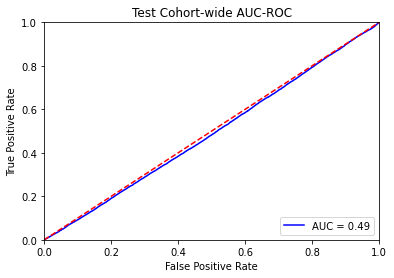

In [49]:
#from sophie's code - viz. the curve 
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

# fpr and tpr of all thresohlds
true = ground_truth
preds = probabilities[:, 1]
fpr, tpr, threshold = metrics.roc_curve(true, preds)

#get the metrics 
roc_auc = metrics.auc(fpr, tpr)

#plot
plt.title('Test Cohort-wide AUC-ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [16]:
!nvidia-smi

Sat Dec 24 02:12:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:18:00.0 Off |                    0 |
| N/A   37C    P0    54W / 300W |   3046MiB / 32768MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   

In [17]:
torch.cuda.device_count()

4